<a href="https://colab.research.google.com/github/hanahh080601/Colab/blob/main/Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!ls
!unzip face-mask-12k-images-dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/Withou

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
#import shutil
#import glob
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D 
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
#from keras import backend as K


In [ ]:
train_data = image_dataset_from_directory('/content/Face Mask Dataset/Train/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
test_data = image_dataset_from_directory('/content/Face Mask Dataset/Test/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
valid_data = image_dataset_from_directory('/content/Face Mask Dataset/Validation/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [ ]:
def plot(dataset, classes):
  #plt.style.use('dark_background')
  plt.figure(figsize=(10,10))
  for img, label in dataset.take(1):
      for i in range(25):
          ax = plt.subplot(5,5,i+1)
          plt.imshow(img[i].numpy().astype('uint8'))
          plt.title(classes[int(label[i])])
          plt.axis('off')

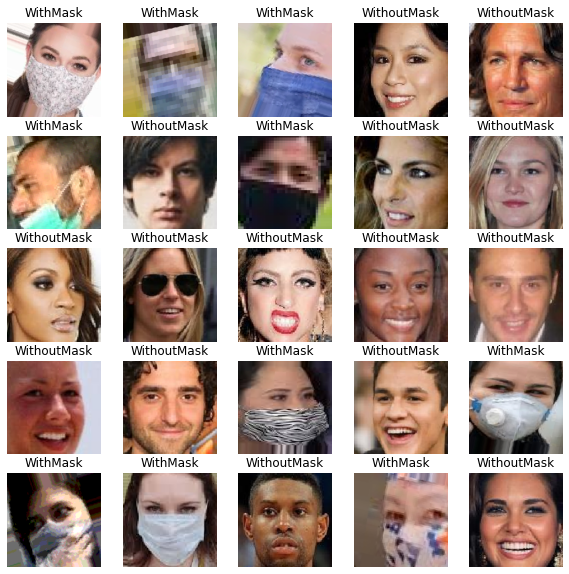

In [ ]:
classes_train = train_data.class_names
plot(train_data, classes_train)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_directory('/content/Face Mask Dataset/Train',
                                              target_size=(200, 200), batch_size=64,
                                              class_mode='binary',  color_mode='rgb')
val_gen = train_datagen.flow_from_directory('/content/Face Mask Dataset/Validation',
                                            target_size=(200, 200), class_mode='binary', color_mode='rgb',
                                            batch_size=64)
test_gen = test_datagen.flow_from_directory('/content/Face Mask Dataset/Test',
                                            target_size=(200, 200), class_mode='binary', color_mode='rgb',
                                            batch_size=64)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.densenet.DenseNet201(weights='imagenet', input_shape = (200,200,3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               576300    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [ ]:
#initial_learning_rate = 1e-2,final_learning_rate = 1e-6,decay_steps = 10000
learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=10, mode='auto',
                                              restore_best_weights=False, verbose=1),
             ModelCheckpoint(filepath='mask_detection_model.h5', monitor='accuracy', save_best_only=True,
                             save_weights_only=False,
                             mode='auto', save_freq='epoch', verbose=1)]

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10, steps_per_epoch=len(train_gen),
                    callbacks=[callbacks], verbose=1)

Epoch 1/10
157/157 [==============================] - 188s 908ms/step - loss: 0.6777 - accuracy: 0.6142 - val_loss: 0.4596 - val_accuracy: 0.8913

Epoch 00001: accuracy improved from -inf to 0.61420, saving model to mask_detection_model.h5
Epoch 2/10
157/157 [==============================] - 134s 854ms/step - loss: 0.4871 - accuracy: 0.7731 - val_loss: 0.3082 - val_accuracy: 0.9450

Epoch 00002: accuracy improved from 0.61420 to 0.77310, saving model to mask_detection_model.h5
Epoch 3/10
157/157 [==============================] - 134s 853ms/step - loss: 0.3662 - accuracy: 0.8571 - val_loss: 0.2292 - val_accuracy: 0.9400

Epoch 00003: accuracy improved from 0.77310 to 0.85710, saving model to mask_detection_model.h5
Epoch 4/10
157/157 [==============================] - 133s 847ms/step - loss: 0.2881 - accuracy: 0.8948 - val_loss: 0.1538 - val_accuracy: 0.9712

Epoch 00004: accuracy improved from 0.85710 to 0.89480, saving model to mask_detection_model.h5
Epoch 5/10
157/157 [===========

In [ ]:
loss, accuracy = model.evaluate(test_gen)

16/16 [==============================] - 8s 462ms/step - loss: 0.0305 - accuracy: 0.9940


In [ ]:
model.save('mask_detection_model.h5')